# OPTIMIZACIÓN Y PRIORIZACIÓN  DE ATENCIÓN DE FALLAS EN PALAS MINERAS MEDIANTE ML Y LLM

Eduardo Jopia Fernandez

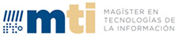


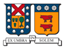

2.2 Marco metodológico CRISP-DM y la relevancia de la calidad de los datos

El enfoque metodológico CRISP-DM (Cross-Industry Standard Process for Data Mining) constituye el marco estructural más utilizado para el desarrollo de proyectos de minería de datos y aprendizaje automático. Su propósito es garantizar un proceso ordenado, repetible y escalable que permita transformar datos crudos en conocimiento accionable, reduciendo la dependencia de la experiencia individual y mejorando la reproducibilidad de los resultados (Wirth & Hipp, 2000).

Estructura y fases del modelo

CRISP-DM propone un ciclo de vida compuesto por seis fases interconectadas: comprensión del negocio, comprensión de los datos, preparación de los datos, modelado, evaluación e implementación. Estas fases no siguen una secuencia estricta, sino que forman un ciclo iterativo, donde los aprendizajes obtenidos retroalimentan el proceso en etapas posteriores.

•	Comprensión del negocio: busca definir los objetivos del proyecto desde una perspectiva operativa, traduciendo los requerimientos técnicos en términos de valor para la organización.

•	Comprensión de los datos: incluye la recolección inicial, análisis exploratorio y diagnóstico de calidad, identificando posibles inconsistencias o vacíos informativos.

•	Preparación de los datos: se centra en la selección, limpieza, integración y transformación de los datos para su uso en los modelos. En esta fase se estima que se invierte entre 60% y 70% del tiempo total de un proyecto de minería de datos, debido a la complejidad de depurar y estandarizar los registros.

•	Modelado: selección y entrenamiento de algoritmos adecuados (regresión, árboles, redes neuronales, clustering, entre otros) y ajuste de hiperparámetros.

•	Evaluación: análisis del rendimiento de los modelos en función de los objetivos de negocio y validación cruzada de resultados.

•	Implementación: integración del modelo en sistemas operacionales o plataformas de apoyo a la decisión, considerando aspectos de mantenimiento y monitoreo continuo.

 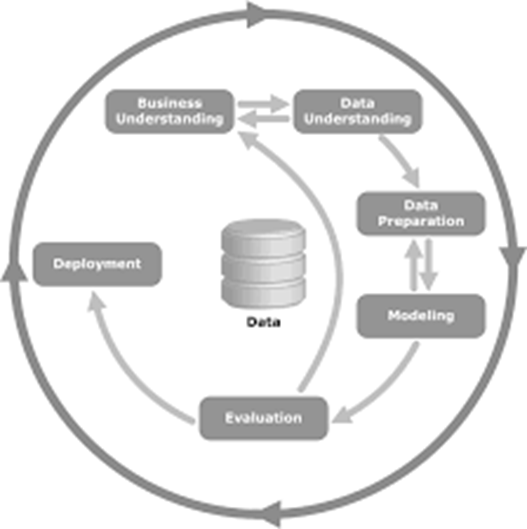

Figura 1. Ciclo del marco teórico de CRISP-DM

La calidad de los datos como fase crítica:

Uno de los aportes más relevantes del enfoque CRISP-DM es la importancia central que otorga a la calidad y consistencia de los datos. La confiabilidad de los modelos predictivos depende directamente de la calidad del conjunto de entrenamiento. Datos incompletos, duplicados o mal estructurados pueden inducir sesgos y degradar la capacidad predictiva del modelo (Fayyad, Piatetsky-Shapiro & Smyth, 1996).

En entornos industriales, como la minería, este desafío se intensifica debido a que los sistemas operativos por ejemplo, sistemas de despacho, mantenimiento o sensores generan datos heterogéneos y dispersos. La etapa de data cleaning y data integration implica integrar múltiples fuentes, eliminar registros outlier y crear variables derivadas que capturen relaciones temporales y espaciales relevantes. Adicionalmente, la gestión de la calidad de los datos debe entenderse como un proceso continuo, no como una tarea previa al modelado. Para ello, se recomienda implementar mecanismos automáticos de validación y monitoreo en las fases posteriores del ciclo, de modo que la calidad se mantenga cuando los modelos pasen a un entorno productivo en tiempo real.


Montar Drive y localizar archivos

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os, re

BASE_DIR = "/content/drive/MyDrive/datos_hist_mant"

# Listado para verificar
print("Directorio base:", BASE_DIR)
for f in os.listdir(BASE_DIR):
    if f.lower().endswith((".xlsx",".xls")):
        print(" -", f)

# Selección automática por palabras clave (tolerante a sufijos como (10), (3), etc.)
def pick_file_by_keywords(base_dir, must_keywords):
    cands = []
    for f in os.listdir(base_dir):
        if not f.lower().endswith((".xlsx",".xls")):
            continue
        name_lower = f.lower()
        if all(k.lower() in name_lower for k in must_keywords):
            cands.append(f)
    if not cands:
        return None
    # Heurística: prioriza el nombre más corto (menos ruido)
    cands.sort(key=len)
    return os.path.join(base_dir, cands[0])

PATH_KPI     = pick_file_by_keywords(BASE_DIR, ["kpi", "mantencion"])
PATH_DETALLE = pick_file_by_keywords(BASE_DIR, ["detalle", "mantencion"])

print("\nArchivo KPI seleccionado:", PATH_KPI)
print("Archivo DETALLE seleccionado:", PATH_DETALLE)


Mounted at /content/drive
Directorio base: /content/drive/MyDrive/datos_hist_mant
 - Detalle de Tiempos Mantencion.xlsx
 - KPI Mantencion_V2.xlsx

Archivo KPI seleccionado: /content/drive/MyDrive/datos_hist_mant/KPI Mantencion_V2.xlsx
Archivo DETALLE seleccionado: /content/drive/MyDrive/datos_hist_mant/Detalle de Tiempos Mantencion.xlsx


Lectura de datos

In [3]:
import pandas as pd
import unicodedata

def norm(s: str) -> str:
    if s is None: return ""
    s = unicodedata.normalize("NFKD", str(s)).encode("ascii","ignore").decode("utf-8")
    s = re.sub(r"[^a-zA-Z0-9\s]", " ", s).lower()
    s = re.sub(r"\s+", " ", s).strip()
    return s

def detect_header_row(df: pd.DataFrame, mode: str) -> int | None:
    """
    Detecta la fila del encabezado:
    - mode='kpi': busca fila que contenga 'equipo' y ('mant' & 'no' & 'prog') o algo de fecha/tiempo.
    - mode='detalle': 'equipo' y ('descripcion' o 'comentario' o 'categoria' o 'fecha'/'time').
    """
    for i in range(min(40, len(df))):
        vals = [norm(x) for x in df.iloc[i].astype(str).tolist()]
        joined = " ".join(vals)
        if "equipo" in joined:
            if mode == "kpi":
                if (("mant" in joined and "no" in joined and "prog" in joined) or
                    ("fecha" in joined) or ("tiempo" in joined) or ("time" in joined)):
                    return i
            else:
                if (("descripcion" in joined) or ("comentario" in joined) or ("categoria" in joined) or
                    ("fecha" in joined) or ("time" in joined)):
                    return i
    # Fallback: primera fila que contenga 'equipo'
    for i in range(min(40, len(df))):
        vals = [norm(x) for x in df.iloc[i].astype(str).tolist()]
        if any("equipo" in v for v in vals):
            return i
    return None

def read_excel_with_header_autodetect(path: str, mode: str) -> pd.DataFrame:
    xls = pd.ExcelFile(path)
    sheet_ok, hdr_idx = None, None
    # Encuentra la primera hoja que cumpla
    for sh in xls.sheet_names:
        tmp = pd.read_excel(path, sheet_name=sh, header=None)
        hdr = detect_header_row(tmp, mode)
        if hdr is not None:
            sheet_ok, hdr_idx = sh, hdr
            break
    if sheet_ok is None:
        raise ValueError(f"No se detectó encabezado en {path}. Revisa el archivo y la hoja.")
    tmp = pd.read_excel(path, sheet_name=sheet_ok, header=None)
    hdr_idx = detect_header_row(tmp, mode)
    if hdr_idx is None:
        raise ValueError(f"No se encontró fila de encabezado en la hoja {sheet_ok} de {path}.")
    columns = tmp.iloc[hdr_idx].astype(str).tolist()
    df = tmp.iloc[hdr_idx+1:].reset_index(drop=True).copy()
    df.columns = columns
    return df

# Leer archivos con autodetección
df_kpi_raw     = read_excel_with_header_autodetect(PATH_KPI, mode="kpi")
df_detalle_raw = read_excel_with_header_autodetect(PATH_DETALLE, mode="detalle")

def clean_cols(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = (df.columns
                  .str.normalize('NFKD').str.encode('ascii','ignore').str.decode('utf-8')
                  .str.replace(r'\s+', ' ', regex=True)
                  .str.strip())
    return df

df_kpi     = clean_cols(df_kpi_raw)
df_detalle = clean_cols(df_detalle_raw)

print("Columnas KPI leídas:")
print(df_kpi.columns.tolist())
print("\nColumnas DETALLE leídas:")
print(df_detalle.columns.tolist())

display(df_kpi.head(3))
display(df_detalle.head(3))


Columnas KPI leídas:
['nan', 'Tiempo', 'Turno', 'Guardia', 'Equipo', 'nan', 'Horas Ope.', 'Efectivo', 'Demora Prog.', 'nan', 'Demora No Prog.', 'Perdida Operaci', 'nan', 'Reserva', 'Mant. Preve', 'Mant. Origen Operacion', 'Mant. Prog.', 'Mant No Prog.', 'Mant No Prog. 2', 'Tiempo Total', 'Nro. Deten', '% Disp. Mecanica', '% Disp. Fisica', '% Util Efectiva', '% Uso']

Columnas DETALLE leídas:
['Flota', 'nan', 'Equipo', 'nan', 'Fecha Hora Inicio', 'Fecha Hora Final', 'Duracion', 'nan', 'Codigo', 'Descripcion', 'nan', 'Categoria', 'Comentario', 'Turno', 'Grupo']


,nan,Tiempo,Turno,Guardia,Equipo,nan,Horas Ope.,Efectivo,Demora Prog.,nan,...,Mant. Origen Operacion,Mant. Prog.,Mant No Prog.,Mant No Prog. 2,Tiempo Total,Nro. Deten,% Disp. Mecanica,% Disp. Fisica,% Util Efectiva,% Uso
0,NaN,01/01/2025,B,G2,PA1,NaN,10.426944,6.7875,0.393611,NaN,...,0,0,1.573055,1.573055,12,1,0.868912,0.868912,0.650958,1
1,NaN,01/01/2025,A,G4,PA1,NaN,12.0,6.85139,0.288889,NaN,...,0,0,0,0,12,0,1,1.0,0.570949,1
2,NaN,01/01/2025,A,G4,PA2,NaN,12,3.330834,0,NaN,...,0,0,0,0,12,0,1,1,0.27757,1


,Flota,nan,Equipo,nan,Fecha Hora Inicio,Fecha Hora Final,Duracion,nan,Codigo,Descripcion,nan,Categoria,Comentario,Turno,Grupo
0,P&H 4100 XPC,NaN,PA1,NaN,08/02/2025 04:25:37,08/02/2025 04:49:28,0:23:51,NaN,109,Inspeccion,NaN,Mantencion Preventiva,InspecciÃ³n GET // OPERATIVO 04:48,B,Grupo 3
1,P&H 4100 XPC,NaN,PA1,NaN,21/02/2025 16:58:30,21/02/2025 18:00:00,1:1:30,NaN,361,Traslado,NaN,Mantencion Planificada,Traslado patio de mantenciÃ³n,A,Grupo 3
2,P&H 4100 XPC,NaN,PA1,NaN,23/01/2025 00:27:38,23/01/2025 06:27:16,5:59:38,NaN,1000,Averia,NaN,Mantencion Origen Mantencion,Equipo se detiene sin codigos activos,B,Grupo 1


normalización

In [4]:
import numpy as np

def find_col(df: pd.DataFrame, must_have=None, any_of=None, exclude=None):
    """Devuelve el nombre de la primera columna cuyo nombre normalizado cumpla las condiciones."""
    must_have = [norm(x) for x in (must_have or [])]
    any_of    = [norm(x) for x in (any_of or [])]
    exclude   = [norm(x) for x in (exclude or [])]
    best, best_len = None, 10**9
    for c in df.columns:
        nc = norm(c)
        if all(tok in nc for tok in must_have) and (not any_of or any(tok in nc for tok in any_of)) and all(ex not in nc for ex in exclude):
            if len(nc) < best_len:
                best, best_len = c, len(nc)
    return best  # puede ser None

def to_float(s):
    if pd.isna(s): return np.nan
    s = str(s).replace("%","").replace(".","").replace(",", ".").strip()
    try: return float(s)
    except: return np.nan

def normalize_equipo(s: str) -> str:
    if pd.isna(s): return s
    s = str(s).upper().strip().replace("-", "")
    s = re.sub(r"^PA0?(\d+)$", r"PA\1", s)
    return s

PALAS = {"PA1","PA2","PA3","PA7","PA14"}


Mapeo + normalización de KPI y cálculo de MTTR_KPI_h

In [5]:
# Identificación de columnas clave en KPI (tolerante a variaciones)
col_equipo_kpi = find_col(df_kpi, must_have=["equipo"])
col_fecha_kpi  = find_col(df_kpi, any_of=["fecha","tiempo","time"])
col_mnp        = find_col(df_kpi, must_have=["mant","no","prog"])  # Mant No Prog (tiempo)
# Si existe explícitamente el número de detenciones no programadas
col_ndnp       = find_col(df_kpi, must_have=["deten"], any_of=["no prog","no program","no programadas","no program"])

print("Mapeo KPI detectado:")
print("  Equipo       ->", col_equipo_kpi)
print("  Fecha/tiempo ->", col_fecha_kpi)
print("  MantNoProg   ->", col_mnp)
print("  NDetNoProg   ->", col_ndnp, "(puede ser None)")

# Validación mínima
if not (col_equipo_kpi and col_fecha_kpi and col_mnp):
    raise ValueError("No se pudieron identificar columnas clave en KPI. Revisa el listado de columnas y ajusta patrones.")

# Renombre canónico y normalización
kpi = df_kpi.rename(columns={
    col_equipo_kpi: "Equipo",
    col_fecha_kpi:  "FechaKPI",
    col_mnp:        "MantNoProg_h",
    **({col_ndnp:   "NDetNoProg"} if col_ndnp else {})
}).copy()

kpi["Equipo"]   = kpi["Equipo"].map(normalize_equipo)
kpi             = kpi[kpi["Equipo"].isin(PALAS)].copy()
kpi["FechaKPI"] = pd.to_datetime(kpi["FechaKPI"], dayfirst=True, errors="coerce")

kpi["MantNoProg_h"] = kpi["MantNoProg_h"].map(to_float)
if "NDetNoProg" in kpi.columns:
    kpi["NDetNoProg"] = kpi["NDetNoProg"].map(to_float)
    kpi["MTTR_KPI_h"] = np.where(kpi["NDetNoProg"]>0, kpi["MantNoProg_h"]/kpi["NDetNoProg"], np.nan)
else:
    kpi["MTTR_KPI_h"] = np.nan  # Lo contrastaremos usando el DETALLE si esta columna no existe

print("\nKPI normalizado (muestra):")
display(kpi[["FechaKPI","Equipo","MantNoProg_h", *(["NDetNoProg"] if "NDetNoProg" in kpi.columns else []), "MTTR_KPI_h"]].head(8))
print("Filas KPI (palas objetivo):", len(kpi))


Mapeo KPI detectado:
  Equipo       -> Equipo
  Fecha/tiempo -> Tiempo
  MantNoProg   -> Mant No Prog.
  NDetNoProg   -> None (puede ser None)

KPI normalizado (muestra):


,FechaKPI,Equipo,MantNoProg_h,MTTR_KPI_h
0,2025-01-01,PA1,15730555.0,NaN
1,2025-01-01,PA1,0.0,NaN
2,2025-01-01,PA2,0.0,NaN
3,2025-01-01,PA2,0.0,NaN
4,2025-01-01,PA3,0.0,NaN
5,2025-01-01,PA3,0.0,NaN
6,2025-01-01,PA7,6636111.0,NaN
7,2025-01-01,PA7,0.0,NaN


Filas KPI (palas objetivo): 2308


Mapeo + normalización de DETALLE y cálculo de MTTR_DET_h

In [6]:
import pandas as pd
import numpy as np
import re

# Reutilizamos: find_col, normalize_equipo, to_float ya definidos

# Identificación de columnas clave (tolerante a variaciones)
col_equipo_det = find_col(df_detalle, must_have=["equipo"])
col_inicio     = find_col(df_detalle, any_of=["inicio","time3","fecha inicio","fecha ini","fecha"])
col_termino    = find_col(df_detalle, any_of=["termino","fin","time4","fecha fin"])
col_tiempo     = find_col(df_detalle, any_of=["tiempo","duracion","hh","mm","ss"])
col_desc       = find_col(df_detalle, any_of=["descripcion"])
col_coment     = find_col(df_detalle, any_of=["comentario"])
col_cat        = find_col(df_detalle, any_of=["categoria"])

print("Mapeo DETALLE detectado:")
print("  Equipo     ->", col_equipo_det)
print("  Inicio     ->", col_inicio)
print("  Termino    ->", col_termino)
print("  TiempoHMS  ->", col_tiempo)
print("  Descripcion->", col_desc)
print("  Comentario ->", col_coment)
print("  Categoria  ->", col_cat)

if not col_equipo_det:
    raise ValueError("No se encontró columna de Equipo en DETALLE.")

# Renombre canónico y normalización
det = df_detalle.rename(columns={
    col_equipo_det: "Equipo",
    **({col_inicio:"Inicio"} if col_inicio else {}),
    **({col_termino:"Termino"} if col_termino else {}),
    **({col_tiempo:"Tiempo_HMS"} if col_tiempo else {}),
    **({col_desc:"Descripcion"} if col_desc else {}),
    **({col_coment:"Comentario"} if col_coment else {}),
    **({col_cat:"Categoria"} if col_cat else {}),
}).copy()

det["Equipo"] = det["Equipo"].map(normalize_equipo)
det           = det[det["Equipo"].isin(PALAS)].copy()

# Parse de tiempos
if "Inicio" in det.columns:
    det["Inicio"]  = pd.to_datetime(det["Inicio"],  dayfirst=True, errors="coerce")
if "Termino" in det.columns:
    det["Termino"] = pd.to_datetime(det["Termino"], dayfirst=True, errors="coerce")

def hms_to_hours(x):
    if pd.isna(x): return np.nan
    m = re.match(r'^\s*(\d+):(\d{1,2}):(\d{1,2})\s*$', str(x))
    if not m: return np.nan
    h, m_, s_ = map(int, m.groups())
    return h + m_/60 + s_/3600

if "Tiempo_HMS" in det.columns:
    det["MTTR_DET_h"] = det["Tiempo_HMS"].map(hms_to_hours)
elif "Inicio" in det.columns and "Termino" in det.columns:
    det["MTTR_DET_h"] = (det["Termino"] - det["Inicio"]).dt.total_seconds()/3600
else:
    det["MTTR_DET_h"] = np.nan

# Fecha de día (para join diario)
if "Inicio" in det.columns:
    det["FechaDET"] = det["Inicio"].dt.floor("D")
elif "Termino" in det.columns:
    det["FechaDET"] = det["Termino"].dt.floor("D")
else:
    det["FechaDET"] = pd.NaT

print("\nDETALLE normalizado (muestra):")
display(det[["FechaDET","Equipo","MTTR_DET_h","Categoria",
             *(["Descripcion"] if "Descripcion" in det.columns else []),
             *(["Comentario"]  if "Comentario"  in det.columns else [])]].head(8))
print("Filas DETALLE (palas objetivo):", len(det))


Mapeo DETALLE detectado:
  Equipo     -> Equipo
  Inicio     -> Fecha Hora Final
  Termino    -> Fecha Hora Final
  TiempoHMS  -> Duracion
  Descripcion-> Descripcion
  Comentario -> Comentario
  Categoria  -> Categoria

DETALLE normalizado (muestra):


,FechaDET,Equipo,MTTR_DET_h,Categoria,Descripcion,Comentario
0,2025-02-08,PA1,0.397500,Mantencion Preventiva,Inspeccion,InspecciÃ³n GET // OPERATIVO 04:48
1,2025-02-21,PA1,1.025000,Mantencion Planificada,Traslado,Traslado patio de mantenciÃ³n
2,2025-01-23,PA1,5.993889,Mantencion Origen Mantencion,Averia,Equipo se detiene sin codigos activos
3,2025-02-12,PA1,5.388333,Mantencion Origen Mantencion,Sistema Neumatico,Sin arranque compresores principales
4,2025-03-12,PA1,0.253889,Mantencion Origen Mantencion,Balde,Ajuste de pestillo
5,2025-03-12,PA1,3.700000,Mantencion Origen Mantencion,Balde,Cable diper trip destensado. evacuacion por tr...
6,2025-03-04,PA1,5.300000,Mantencion Origen Mantencion,Sistema Electrico Control,Sin partida. Falla driver campo empuje. CAmbio...
7,2025-01-02,PA1,1.573056,Mantencion Origen Mantencion,Sistema Propulsion,"Falla de propulsion, se revisan sistemas asoci..."


Filas DETALLE (palas objetivo): 1267


AED sobre MTTR (DETALLE) y conteos

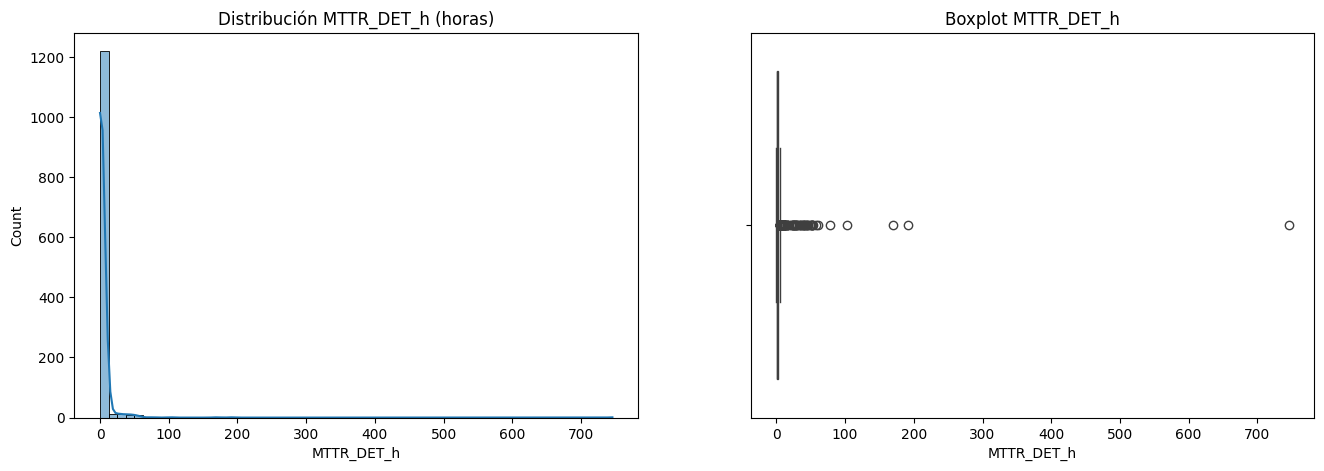

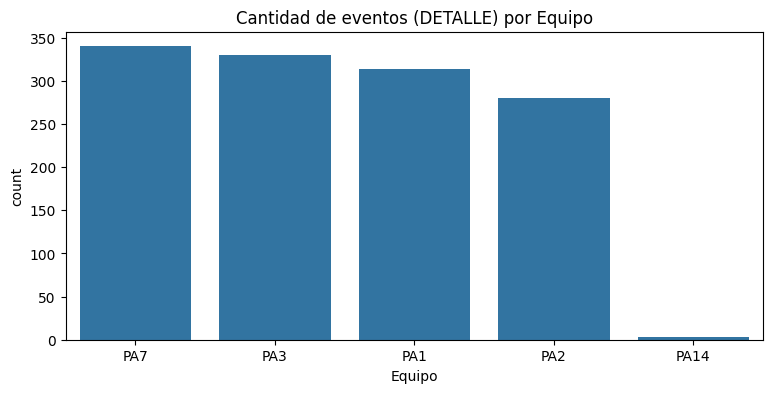

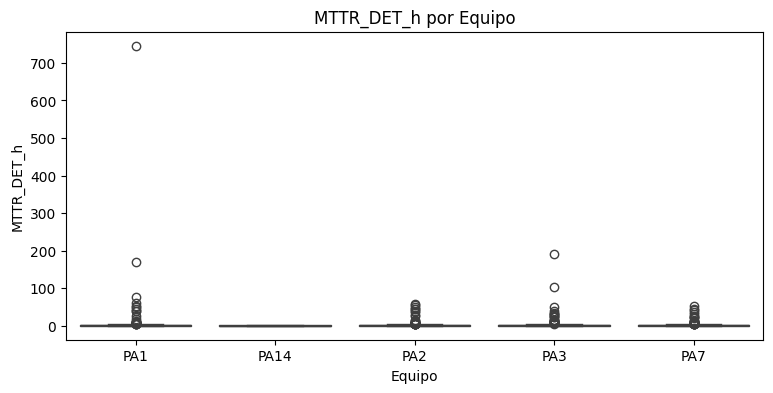

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribución de MTTR en detalle
if det["MTTR_DET_h"].notna().sum() > 0:
    fig, ax = plt.subplots(1,2, figsize=(16,5))
    sns.histplot(det["MTTR_DET_h"].dropna(), bins=60, kde=True, ax=ax[0])
    ax[0].set_title("Distribución MTTR_DET_h (horas)")
    sns.boxplot(x=det["MTTR_DET_h"].dropna(), ax=ax[1])
    ax[1].set_title("Boxplot MTTR_DET_h")
    plt.show()

# Conteo de eventos por equipo
plt.figure(figsize=(9,4))
order = det["Equipo"].value_counts().index
sns.countplot(x="Equipo", data=det, order=order)
plt.title("Cantidad de eventos (DETALLE) por Equipo")
plt.show()

# MTTR por equipo
plt.figure(figsize=(9,4))
sns.boxplot(x="Equipo", y="MTTR_DET_h", data=det)
plt.title("MTTR_DET_h por Equipo")
plt.show()


Focalizar “imprevistas” (Categoría)

Eventos imprevistos (DETALLE): 785


,FechaDET,Equipo,MTTR_DET_h,Categoria
2,2025-01-23,PA1,5.993889,Mantencion Origen Mantencion
3,2025-02-12,PA1,5.388333,Mantencion Origen Mantencion
4,2025-03-12,PA1,0.253889,Mantencion Origen Mantencion
5,2025-03-12,PA1,3.700000,Mantencion Origen Mantencion
6,2025-03-04,PA1,5.300000,Mantencion Origen Mantencion


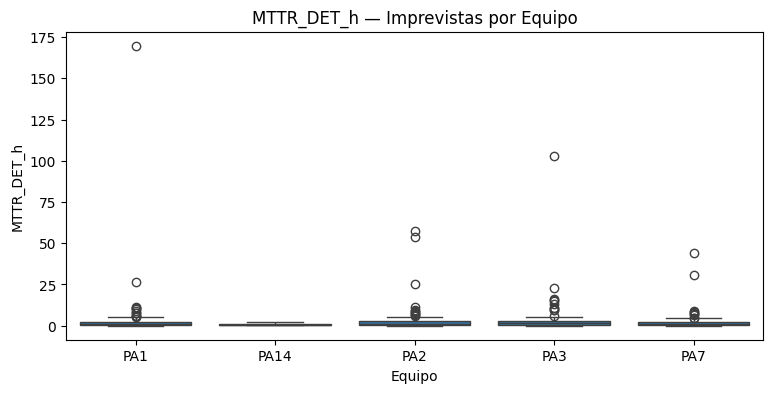


Top categorías en DETALLE:


,count
Categoria,
Mantencion Origen Mantencion,785
Mantencion Planificada,209
Mantencion Preventiva,179
Mantencion Origen Operacional,92
Demora Programada,2


In [8]:
mask_imp = det["Categoria"].fillna("").str.contains("Mantencion origen Mantencion", case=False, regex=False)
det_imp  = det[mask_imp].copy()

print("Eventos imprevistos (DETALLE):", len(det_imp))
display(det_imp[["FechaDET","Equipo","MTTR_DET_h","Categoria"]].head(5))

# MTTR imprevistas por equipo
if len(det_imp) > 0:
    plt.figure(figsize=(9,4))
    sns.boxplot(x="Equipo", y="MTTR_DET_h", data=det_imp)
    plt.title("MTTR_DET_h — Imprevistas por Equipo")
    plt.show()

# Top categorías reales (por si hubiese variantes)
if "Categoria" in det.columns:
    print("\nTop categorías en DETALLE:")
    display(det["Categoria"].value_counts().head(10))


Integración diaria DETALLE↔KPI por (Equipo, fecha)

In [9]:
# KPI diario por (Equipo, FechaKPI)
kpi_day = (kpi
           .groupby(["Equipo","FechaKPI"], as_index=False)
           .agg({"MantNoProg_h":"sum",
                 **({"NDetNoProg":"sum"} if "NDetNoProg" in kpi.columns else {}),
                 "MTTR_KPI_h":"mean"}))

# DETALLE: agregación diaria por (Equipo, FechaDET)
det_day = (det
           .groupby(["Equipo","FechaDET"], as_index=False)
           .agg(events_detalle=("MTTR_DET_h","size"),
                MTTR_DET_prom=("MTTR_DET_h","mean"),
                MTTR_DET_med=("MTTR_DET_h","median"),
                MTTR_DET_sum=("MTTR_DET_h","sum")))

# Join diario
base_day = det_day.merge(kpi_day, left_on=["Equipo","FechaDET"], right_on=["Equipo","FechaKPI"], how="left")

print("Base diaria integrada (muestra):")
display(base_day.head(10))

print("\nCobertura KPI en días con eventos de detalle:",
      base_day["MantNoProg_h"].notna().mean().round(3))


Base diaria integrada (muestra):


,Equipo,FechaDET,events_detalle,MTTR_DET_prom,MTTR_DET_med,MTTR_DET_sum,FechaKPI,MantNoProg_h,MTTR_KPI_h
0,PA1,2025-01-02,1,1.573056,1.573056,1.573056,2025-01-02,54725.0,NaN
1,PA1,2025-01-03,5,1.991056,1.855556,9.955278,2025-01-03,44372222.0,NaN
2,PA1,2025-01-05,1,1.245556,1.245556,1.245556,2025-01-05,12455555.0,NaN
3,PA1,2025-01-06,2,0.904722,0.904722,1.809444,2025-01-06,18.0,NaN
4,PA1,2025-01-07,1,0.140556,0.140556,0.140556,2025-01-07,1405555.0,NaN
5,PA1,2025-01-08,2,0.102222,0.102222,0.204444,2025-01-08,0.0,NaN
6,PA1,2025-01-10,1,1.606111,1.606111,1.606111,2025-01-10,16061111.0,NaN
7,PA1,2025-01-18,1,169.762222,169.762222,169.762222,2025-01-18,119969456.0,NaN
8,PA1,2025-01-19,3,10.325648,4.373889,30.976944,2025-01-19,197594443.0,NaN
9,PA1,2025-01-20,3,2.817593,3.419444,8.452778,2025-01-20,44772222.0,NaN



Cobertura KPI en días con eventos de detalle: 1.0


Gráficos de contraste (si hay cobertura suficiente):

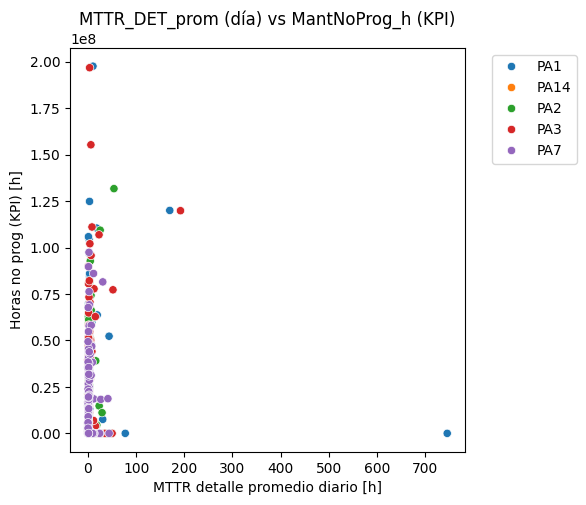

In [10]:
# Scatter: MTTR promedio (DETALLE) vs MantNoProg_h (KPI) — por día
if base_day["MantNoProg_h"].notna().sum() > 0:
    plt.figure(figsize=(6,5))
    sns.scatterplot(data=base_day, x="MTTR_DET_prom", y="MantNoProg_h", hue="Equipo")
    plt.title("MTTR_DET_prom (día) vs MantNoProg_h (KPI)")
    plt.xlabel("MTTR detalle promedio diario [h]")
    plt.ylabel("Horas no prog (KPI) [h]")
    plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
    plt.tight_layout()
    plt.show()

# Si disponemos de NDetNoProg, verificamos relación con events_detalle
if "NDetNoProg" in base_day.columns and base_day["NDetNoProg"].notna().sum() > 0:
    plt.figure(figsize=(6,5))
    sns.scatterplot(data=base_day, x="events_detalle", y="NDetNoProg", hue="Equipo")
    plt.title("# eventos detalle (día) vs NDetNoProg (KPI)")
    plt.xlabel("# eventos (detalle)")
    plt.ylabel("# detenciones no programadas (KPI)")
    plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
    plt.tight_layout()
    plt.show()


Exportar datasets base (para minería y modelo)

In [11]:
import os
OUT_DIR = os.path.join(BASE_DIR, "out")
os.makedirs(OUT_DIR, exist_ok=True)

det_path     = os.path.join(OUT_DIR, "detalle_normalizado.csv")
kpi_path     = os.path.join(OUT_DIR, "kpi_normalizado.csv")
base_day_path= os.path.join(OUT_DIR, "integrado_diario.csv")

det.to_csv(det_path, index=False, encoding="utf-8")
kpi.to_csv(kpi_path, index=False, encoding="utf-8")
base_day.to_csv(base_day_path, index=False, encoding="utf-8")

print("Guardados:")
print(" -", det_path)
print(" -", kpi_path)
print(" -", base_day_path)


Guardados:
 - /content/drive/MyDrive/datos_hist_mant/out/detalle_normalizado.csv
 - /content/drive/MyDrive/datos_hist_mant/out/kpi_normalizado.csv
 - /content/drive/MyDrive/datos_hist_mant/out/integrado_diario.csv


Preparar corpus de texto (imprevistas)

In [12]:
import pandas as pd
import numpy as np

# 1) Subconjunto imprevistas
mask_imp = det["Categoria"].fillna("").str.contains("Mantencion origen Mantencion", case=False, regex=False)
det_imp  = det[mask_imp].copy()

# 2) Campo de texto base (Comentario > Descripcion)
texto_cols = [c for c in ["Comentario","Descripcion"] if c in det_imp.columns]
if not texto_cols:
    raise ValueError("No hay columnas de texto ('Comentario' o 'Descripcion') en DETALLE.")

det_imp["texto"] = det_imp[texto_cols].bfill(axis=1).iloc[:,0].astype(str)

# 3) Limpieza rápida de texto (minúsculas y espacios)
def clean_text(s: str) -> str:
    s = s.lower().strip()
    # Remueve etiquetas genéricas irrelevantes del dominio (ajusta si ves ruido)
    bad_tokens = [" pa1 "," pa2 "," pa3 "," pa7 "," pa14 "," pala "," equipo "]
    s = " " + s + " "
    for t in bad_tokens:
        s = s.replace(t, " ")
    return " ".join(s.split())

det_imp["texto_clean"] = det_imp["texto"].map(clean_text)

# 4) Filtro de longitud mínima (para evitar ruido)
det_imp = det_imp[det_imp["texto_clean"].str.len() >= 10].copy()

print("Eventos imprevistos con texto utilizable:", len(det_imp))
display(det_imp[["FechaDET","Equipo","MTTR_DET_h","Categoria","texto_clean"]].head(5))


Eventos imprevistos con texto utilizable: 770


,FechaDET,Equipo,MTTR_DET_h,Categoria,texto_clean
2,2025-01-23,PA1,5.993889,Mantencion Origen Mantencion,se detiene sin codigos activos
3,2025-02-12,PA1,5.388333,Mantencion Origen Mantencion,sin arranque compresores principales
4,2025-03-12,PA1,0.253889,Mantencion Origen Mantencion,ajuste de pestillo
5,2025-03-12,PA1,3.700000,Mantencion Origen Mantencion,cable diper trip destensado. evacuacion por tr...
6,2025-03-04,PA1,5.300000,Mantencion Origen Mantencion,sin partida. falla driver campo empuje. cambio...


***ML No supervisado***
Vectorización TF-IDF y búsqueda de k (KMeans)

Stopwords en español (NLTK) + extras de dominio

In [13]:
# Stopwords ES con NLTK
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

spanish_stopwords = set(stopwords.words('spanish'))

# Stopwords de dominio (ajusta a gusto)
domain_stops = {
    'pa1','pa2','pa3','pa7','pa14', 'pala','equipo','mantencion','mantenimiento',
    'no','prog','programada','programado','imprevista','imprevisto'
}
spanish_stopwords = spanish_stopwords.union(domain_stops)

len(spanish_stopwords), list(sorted(list(domain_stops)))[:10]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


(327,
 ['equipo',
  'imprevista',
  'imprevisto',
  'mantencion',
  'mantenimiento',
  'no',
  'pa1',
  'pa14',
  'pa2',
  'pa3'])

Vectorización TF-IDF y búsqueda de k

Matriz TF-IDF: (770, 329) | min_df usado: 5


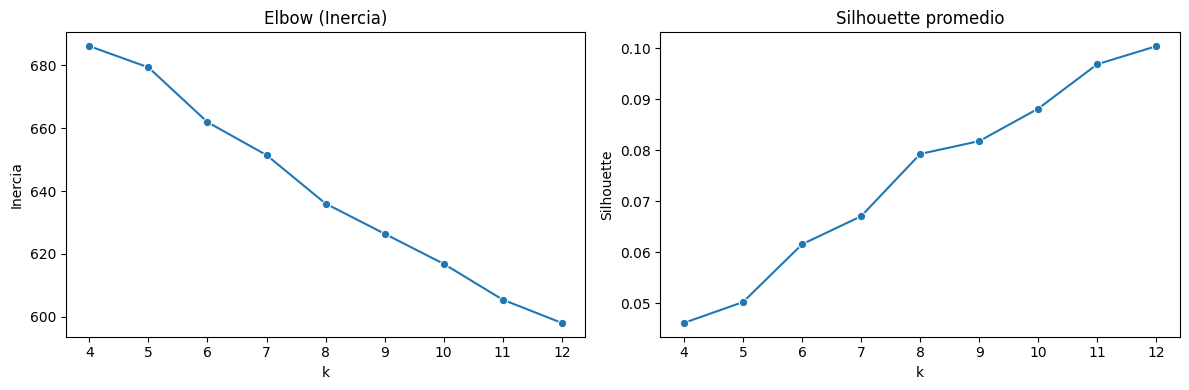

Resumen k:
k= 4  inercia=686  silhouette=0.046
k= 5  inercia=679  silhouette=0.050
k= 6  inercia=662  silhouette=0.062
k= 7  inercia=651  silhouette=0.067
k= 8  inercia=636  silhouette=0.079
k= 9  inercia=626  silhouette=0.082
k=10  inercia=617  silhouette=0.088
k=11  inercia=605  silhouette=0.097
k=12  inercia=598  silhouette=0.100


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Vectorizador con stopwords en español
min_df_try = 5  # si el corpus es pequeño, lo reducimos en el try/except
vectorizer = TfidfVectorizer(
    stop_words=list(spanish_stopwords),
    ngram_range=(1,2),
    min_df=min_df_try,
    max_df=0.6
)

# Robustez: si el vocabulario queda vacío, bajamos min_df automáticamente
try:
    X = vectorizer.fit_transform(det_imp["texto_clean"])
except ValueError as e:
    if "empty vocabulary" in str(e).lower():
        min_df_try = max(2, int(0.005 * len(det_imp)))  # 0.5% del corpus, al menos 2
        vectorizer = TfidfVectorizer(
            stop_words=list(spanish_stopwords),
            ngram_range=(1,2),
            min_df=min_df_try,
            max_df=0.7
        )
        X = vectorizer.fit_transform(det_imp["texto_clean"])
    else:
        raise

print("Matriz TF-IDF:", X.shape, "| min_df usado:", min_df_try)

# Búsqueda de k
ks = list(range(4, 13))
inertias, silhouettes = [], []

for k in ks:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(X)
    inertias.append(km.inertia_)
    sil = silhouette_score(X, labels) if len(set(labels)) > 1 and X.shape[0] > k else np.nan
    silhouettes.append(sil)

fig, ax = plt.subplots(1,2, figsize=(12,4))
sns.lineplot(x=ks, y=inertias, marker="o", ax=ax[0])
ax[0].set_title("Elbow (Inercia)"); ax[0].set_xlabel("k"); ax[0].set_ylabel("Inercia")

sns.lineplot(x=ks, y=silhouettes, marker="o", ax=ax[1])
ax[1].set_title("Silhouette promedio"); ax[1].set_xlabel("k"); ax[1].set_ylabel("Silhouette")
plt.tight_layout(); plt.show()

print("Resumen k:")
for k, i_, s_ in zip(ks, inertias, silhouettes):
    print(f"k={k:2d}  inercia={i_:,.0f}  silhouette={s_:.3f}")


Entrenar KMeans con k elegido y describir clústeres

Top términos por cluster:

Cluster 0:
freno, desaplica, desaplica freno, freno levante, levante, freno hoist, desaplicaciã³n freno, desaplicaciã³n, falla desaplicaciã³n, falla, hoist, freno propel

Cluster 1:
sistema, op, aire, cambio, averia, falla sistema, caex, falla, alarma, baja, principal, cabina

Cluster 2:
falla, lubricaciã³n, superior, lubricacion, falla lubricaciã³n, falla lubricacion, lubricaciã³n superior, propulsion, inferior, campo, transferencia, ventilador

Cluster 3:
condiciã³n partida, condiciã³n, partida, partida falla, falla, drive, falla comunicaciã³n, comunicaciã³n, armadura, 12, swing, falla contactor

Cluster 4:
trip, dipper, dipper trip, cable, cable dipper, falla, cortado, trip cortado, trip op, op, diper, cable diper

Cluster 5:
balde, apertura balde, apertura, abre, cable apertura, evaluaciã³n, tapa balde, cambio, tapa, cable, falla apertura, chequeo

Cluster 6:
temperatura, empuje, contactor, alta, alta temperatura, campo, temperatura empuje, campo empuje, 

,n,mttr_mean,mttr_med,mttr_std
cluster,,,,
1,299,3.292516,1.211389,12.414273
2,169,2.561105,1.411667,4.763118
0,80,1.607622,1.171528,1.455417
6,67,1.735991,1.464444,1.270808
4,46,2.625912,1.719167,3.719234
5,44,1.605448,1.238333,1.466768
3,41,2.204072,1.391944,2.132626
7,24,0.697130,0.443750,0.829958


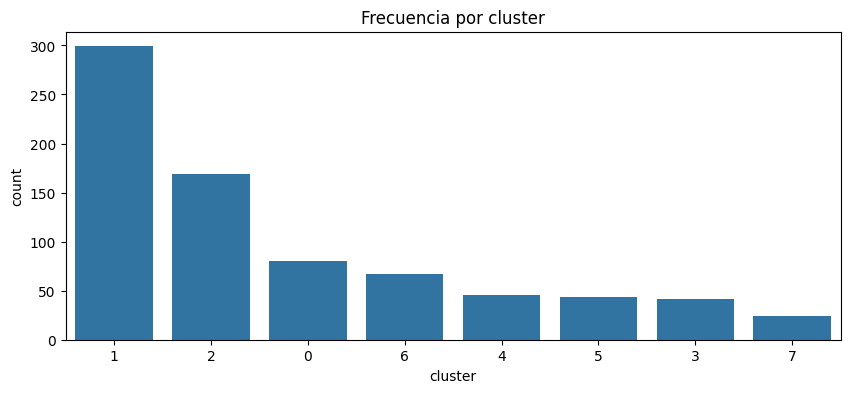

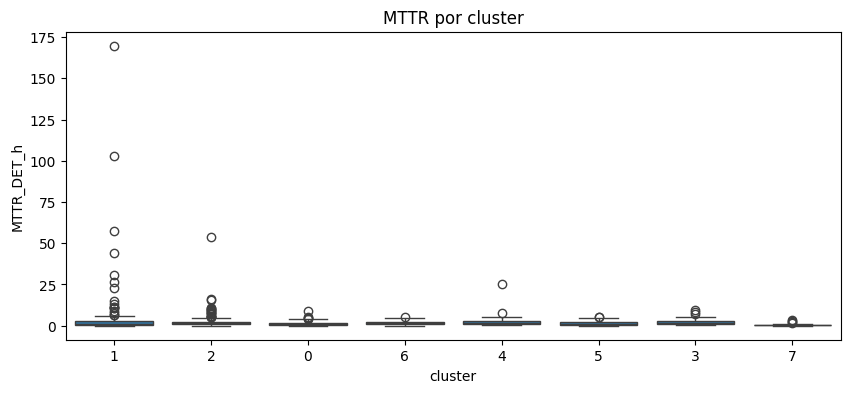


Distribución cluster x Equipo:


Equipo,PA1,PA14,PA2,PA3,PA7
cluster,,,,,
0,7,0,18,27,28
1,81,0,47,95,76
2,43,0,44,43,39
3,11,1,11,7,11
4,10,0,20,14,2
5,10,2,8,15,9
6,14,0,22,10,21
7,10,0,5,3,6


In [15]:
# === elige tu k óptimo (revisa el gráfico del bloque anterior) ===
K_OPTIMO = 8  # <-- AJUSTA AQUÍ

km = KMeans(n_clusters=K_OPTIMO, n_init=10, random_state=42)
det_imp["cluster"] = km.fit_predict(X)

# Términos más representativos por cluster
terms = np.array(vectorizer.get_feature_names_out())
centers = km.cluster_centers_  # shape (k, n_terms)

def top_terms(cluster_id, topn=12):
    idx = np.argsort(centers[cluster_id])[::-1][:topn]
    return terms[idx]

cluster_tops = {c: top_terms(c, topn=12) for c in range(K_OPTIMO)}

print("Top términos por cluster:")
for c, toks in cluster_tops.items():
    print(f"\nCluster {c}:")
    print(", ".join(toks))

# Muestras por cluster
for c in range(K_OPTIMO):
    sample = det_imp[det_imp["cluster"]==c]["texto_clean"].head(3).tolist()
    print(f"\n=== Cluster {c} (muestras) ===")
    for s in sample:
        print(" -", s[:180])

# Distribución por equipo y MTTR por cluster
cluster_stats = det_imp.groupby("cluster").agg(
    n=("cluster","size"),
    mttr_mean=("MTTR_DET_h","mean"),
    mttr_med=("MTTR_DET_h","median"),
    mttr_std=("MTTR_DET_h","std")
).sort_values("n", ascending=False)

print("\nEstadísticas por cluster:")
display(cluster_stats)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,4))
sns.countplot(x="cluster", data=det_imp, order=cluster_stats.index)
plt.title("Frecuencia por cluster")
plt.show()

plt.figure(figsize=(10,4))
sns.boxplot(x="cluster", y="MTTR_DET_h", data=det_imp, order=cluster_stats.index)
plt.title("MTTR por cluster")
plt.show()

# Distribución por equipo dentro de cada cluster
pivot_eq = pd.crosstab(det_imp["cluster"], det_imp["Equipo"])
print("\nDistribución cluster x Equipo:")
display(pivot_eq)


In [16]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=pivot_eq)

https://docs.google.com/spreadsheets/d/1IOwnZZ8vTnE0zUAnLpyZ0Bta7QJr8RVDYepCBi4sXZQ/edit#gid=0


Guardar resultados de clustering

In [17]:
import os
OUT_DIR = os.path.join(BASE_DIR, "out")
os.makedirs(OUT_DIR, exist_ok=True)

det_imp_out = os.path.join(OUT_DIR, "detalle_imprevistas_clusterizado.csv")
det_imp.to_csv(det_imp_out, index=False, encoding="utf-8")
print("Guardado:", det_imp_out)


Guardado: /content/drive/MyDrive/datos_hist_mant/out/detalle_imprevistas_clusterizado.csv


**Modelo Supervisado**

Construir dataset supervisado (evento a evento)
los eventos imprevistos (det_imp) enriquecidos con KPIs del mismo día (join por Equipo + fecha). El objetivo y será MTTR_DET_h.

In [18]:
import pandas as pd
import numpy as np

# 1) Asegurar que tenemos det_imp (de los bloques anteriores)
assert 'det_imp' in globals(), "No encuentro det_imp. Reejecuta los bloques 10–14."

# 2) KPI diario por (Equipo, FechaKPI) ya lo calculamos como kpi_day en el Bloque 8.
#    Si no está en memoria (reiniciaste), lo recomputamos rápido:
if 'kpi_day' not in globals():
    agg_dict = {"MantNoProg_h":"sum"}
    if "NDetNoProg" in kpi.columns: agg_dict["NDetNoProg"] = "sum"
    agg_dict["MTTR_KPI_h"] = "mean"
    kpi_day = (kpi.groupby(["Equipo","FechaKPI"], as_index=False).agg(agg_dict))

# 3) Generar features temporales y de texto simples
df_sup = det_imp.copy()

# Texto base
texto_cols = [c for c in ["texto_clean","Comentario","Descripcion"] if c in df_sup.columns]
df_sup["texto_modelo"] = df_sup[texto_cols].bfill(axis=1).iloc[:,0].astype(str)

# Longitudes como features simples del texto
df_sup["len_chars"] = df_sup["texto_modelo"].str.len()
df_sup["len_words"] = df_sup["texto_modelo"].str.split().apply(len)

# Temporales
if "Inicio" in df_sup.columns and pd.api.types.is_datetime64_any_dtype(df_sup["Inicio"]):
    df_sup["hora"] = df_sup["Inicio"].dt.hour
else:
    df_sup["hora"] = np.nan

df_sup["dow"]  = df_sup["FechaDET"].dt.dayofweek  # 0=Lunes
df_sup["mes"]  = df_sup["FechaDET"].dt.month

# 4) Mantener sólo filas con target
df_sup = df_sup[df_sup["MTTR_DET_h"].notna()].copy()

# 5) Join con KPIs del día (left join)
df_sup = df_sup.merge(
    kpi_day.rename(columns={"FechaKPI":"FechaDET"}),
    on=["Equipo","FechaDET"],
    how="left",
    suffixes=("", "_kpi")
)

# 6) Reducir columnas a lo necesario
keep_cols = [
    "FechaDET","Equipo","MTTR_DET_h","cluster",
    *(["cluster_nombre"] if "cluster_nombre" in df_sup.columns else []),
    "len_chars","len_words","hora","dow","mes",
    "MantNoProg_h", *(["NDetNoProg"] if "NDetNoProg" in df_sup.columns else []), "MTTR_KPI_h"
]
df_sup = df_sup[keep_cols].copy()

# 7) Saneamiento básico
df_sup = df_sup[(df_sup["MTTR_DET_h"] >= 0) & (df_sup["MTTR_DET_h"] < 72)]  # recorte prudente
df_sup = df_sup.dropna(subset=["MTTR_DET_h"])  # y no entrenamos con NaN en y

print("Dataset supervisado (muestra):", df_sup.shape)
display(df_sup.head(8))

print("Porcentaje con KPI diario disponible:",
      df_sup["MantNoProg_h"].notna().mean().round(3))


Dataset supervisado (muestra): (768, 11)


,FechaDET,Equipo,MTTR_DET_h,cluster,len_chars,len_words,hora,dow,mes,MantNoProg_h,MTTR_KPI_h
0,2025-01-23,PA1,5.993889,1,30,5,NaN,3,1,30911111.0,NaN
1,2025-02-12,PA1,5.388333,1,36,4,NaN,2,2,124830555.0,NaN
2,2025-03-12,PA1,0.253889,7,18,3,NaN,2,3,39538888.0,NaN
3,2025-03-12,PA1,3.700000,4,54,7,NaN,2,3,39538888.0,NaN
4,2025-03-04,PA1,5.300000,6,76,12,NaN,1,3,0.0,NaN
5,2025-01-02,PA1,1.573056,2,95,12,NaN,3,1,54725.0,NaN
6,2025-01-19,PA1,26.472778,1,94,14,NaN,6,1,197594443.0,NaN
7,2025-03-18,PA1,0.138889,5,22,4,NaN,1,3,69866666.0,NaN


Porcentaje con KPI diario disponible: 1.0


Partición temporal train/test

In [19]:
# Dividir por fecha (orden temporal)
cutoff = df_sup["FechaDET"].sort_values().quantile(0.8)
train = df_sup[df_sup["FechaDET"] <= cutoff].copy()
test  = df_sup[df_sup["FechaDET"] >  cutoff].copy()

print("Corte temporal:", cutoff.date())
print("Train:", train.shape, " Test:", test.shape)

# Variables
y_train = train["MTTR_DET_h"].values
y_test  = test["MTTR_DET_h"].values

# Definir columnas de features
cat_cols = ["Equipo", "cluster"] + (["cluster_nombre"] if "cluster_nombre" in df_sup.columns else [])
num_cols = ["len_chars","len_words","hora","dow","mes","MantNoProg_h","MTTR_KPI_h"] + \
           (["NDetNoProg"] if "NDetNoProg" in df_sup.columns else [])

# Reemplazar NaN en numéricas por 0 (o imputación más adelante en pipeline)
train[num_cols] = train[num_cols].fillna(0)
test[num_cols]  = test[num_cols].fillna(0)

X_train = train[cat_cols + num_cols]
X_test  = test[cat_cols + num_cols]

print("Features categóricas:", cat_cols)
print("Features numéricas  :", num_cols)


Corte temporal: 2025-07-27
Train: (617, 11)  Test: (151, 11)
Features categóricas: ['Equipo', 'cluster']
Features numéricas  : ['len_chars', 'len_words', 'hora', 'dow', 'mes', 'MantNoProg_h', 'MTTR_KPI_h']


# Modelos (pipelines) y métricas

# Probamos RandomForest, GradientBoosting y Ridge. Elegimos por RMSE.

In [20]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
import numpy as np

# Preprocesador
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", Pipeline([("scaler", StandardScaler())]), num_cols),
    ],
    remainder="drop"
)

candidates = {
    "RandomForest": RandomForestRegressor(
        n_estimators=400, max_depth=None, random_state=42, n_jobs=-1
    ),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "Ridge": Ridge(alpha=1.0)  # <- Ridge no tiene random_state
}

results = {}

for name, model in candidates.items():
    pipe = Pipeline([("prep", preprocess), ("clf", model)])
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    mae  = mean_absolute_error(y_test, pred)
    mse  = mean_squared_error(y_test, pred)     # sin 'squared'
    rmse = np.sqrt(mse)                         # RMSE = sqrt(MSE)
    r2   = r2_score(y_test, pred)
    results[name] = {"pipe": pipe, "mae": mae, "rmse": rmse, "r2": r2}
    print(f"{name:16s} | MAE={mae:.3f}  RMSE={rmse:.3f}  R2={r2:.3f}")

# Selección por RMSE
best_name = min(results, key=lambda k: results[k]["rmse"])
best_pipe = results[best_name]["pipe"]
print(f"\n> Mejor modelo: {best_name}  |  RMSE={results[best_name]['rmse']:.3f}  R2={results[best_name]['r2']:.3f}")


RandomForest     | MAE=1.690  RMSE=5.080  R2=0.070
GradientBoosting | MAE=1.989  RMSE=5.977  R2=-0.287
Ridge            | MAE=1.716  RMSE=5.215  R2=0.020

> Mejor modelo: RandomForest  |  RMSE=5.080  R2=0.070


Diagnóstico del mejor modelo

TEST | MAE=1.690  RMSE=5.080  R2=0.070


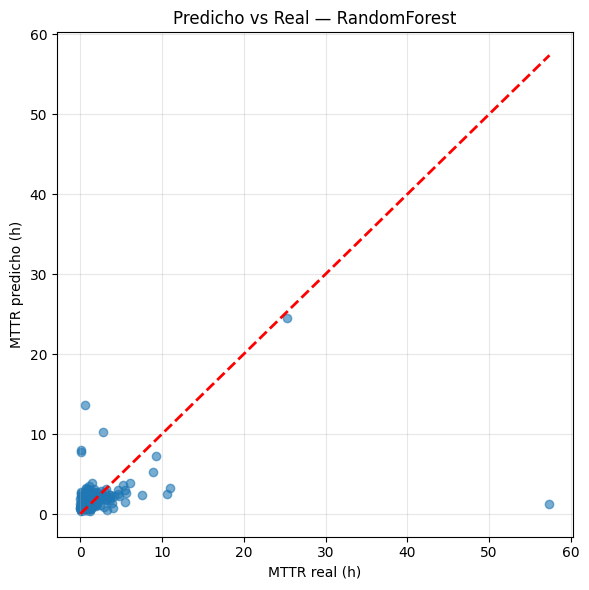

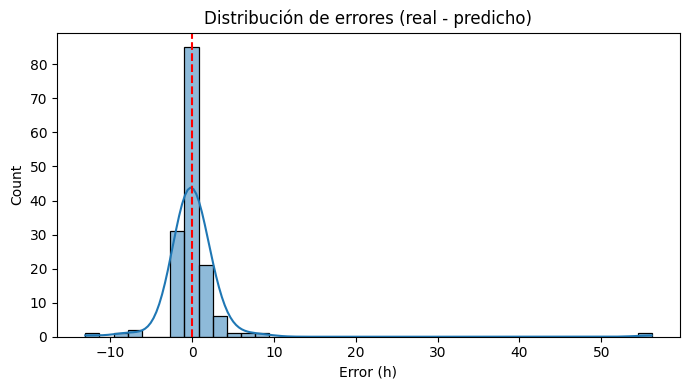


MAE por Equipo:


,MAE
Equipo,
PA2,2.574639
PA1,1.636958
PA3,1.357333
PA7,0.809934



MAE por Cluster:


,MAE
cluster,
1,2.445522
0,2.191382
3,1.427374
4,1.290511
2,1.069099
5,1.046549
6,1.036335
7,0.658693



Top 20 features por importancia:


,feature,importance
18,MantNoProg_h,0.433990
13,len_chars,0.171801
17,mes,0.104289
2,Equipo_PA2,0.072289
14,len_words,0.060214
16,dow,0.055309
6,cluster_1,0.025844
3,Equipo_PA3,0.019320
4,Equipo_PA7,0.016923
7,cluster_2,0.016233


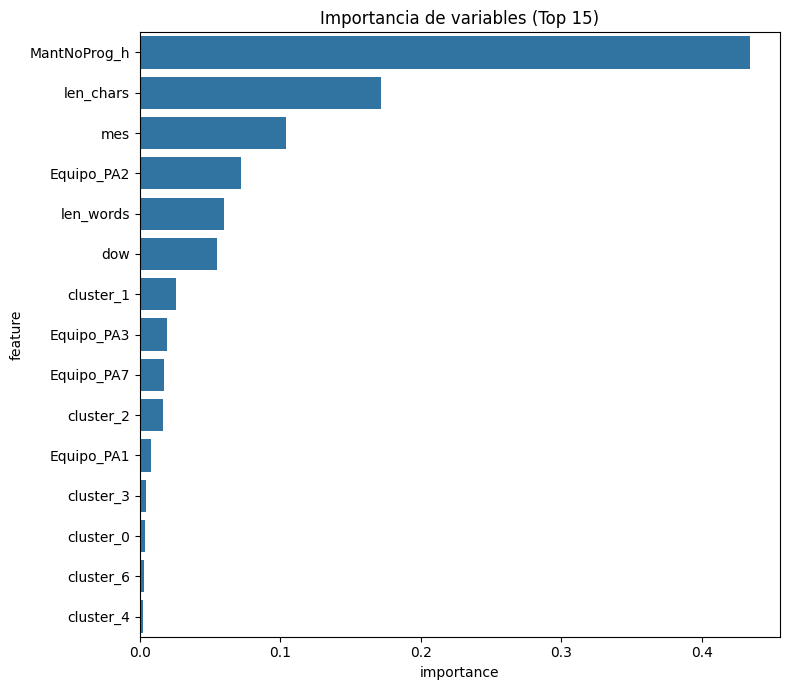

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1) Predicciones test
y_pred = best_pipe.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)
print(f"TEST | MAE={mae:.3f}  RMSE={rmse:.3f}  R2={r2:.3f}")

# 2) Reales vs Predichos
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'r--', lw=2)
plt.xlabel("MTTR real (h)"); plt.ylabel("MTTR predicho (h)")
plt.title(f"Predicho vs Real — {best_name}")
plt.grid(True, alpha=0.3); plt.tight_layout()
plt.show()

# 3) Errores (residuales)
res = y_test - y_pred
plt.figure(figsize=(7,4))
sns.histplot(res, bins=40, kde=True)
plt.axvline(0, color='r', linestyle='--')
plt.title("Distribución de errores (real - predicho)")
plt.xlabel("Error (h)"); plt.tight_layout()
plt.show()

# 4) Métricas por equipo / por cluster
test_eval = test.copy()
test_eval["y"] = y_test
test_eval["yhat"] = y_pred
test_eval["err_abs"] = (test_eval["y"] - test_eval["yhat"]).abs()

print("\nMAE por Equipo:")
display(test_eval.groupby("Equipo")["err_abs"].mean().sort_values(ascending=False).to_frame("MAE"))

if "cluster" in test_eval.columns:
    print("\nMAE por Cluster:")
    display(test_eval.groupby("cluster")["err_abs"].mean().sort_values(ascending=False).to_frame("MAE"))

# 5) Importancias (si el modelo es tree-based)
def get_feature_names(preprocessor, cat_cols, num_cols):
    names = []
    # cat
    ohe = preprocessor.named_transformers_["cat"]
    if hasattr(ohe, "get_feature_names_out"):
        names += list(ohe.get_feature_names_out(cat_cols))
    else:
        # Fallback genérico
        names += [f"cat_{i}" for i in range(len(cat_cols))]
    # num (conservamos los nombres originales)
    names += list(num_cols)
    return names

if best_name in ("RandomForest", "GradientBoosting"):
    clf = best_pipe.named_steps["clf"]
    feat_names = get_feature_names(best_pipe.named_steps["prep"], cat_cols, num_cols)
    importances = getattr(clf, "feature_importances_", None)
    if importances is not None and len(importances) == len(feat_names):
        fi = (pd.DataFrame({"feature": feat_names, "importance": importances})
                .sort_values("importance", ascending=False))
        print("\nTop 20 features por importancia:")
        display(fi.head(20))

        plt.figure(figsize=(8,7))
        sns.barplot(x="importance", y="feature", data=fi.head(15))
        plt.title("Importancia de variables (Top 15)")
        plt.tight_layout(); plt.show()


Validación temporal (TimeSeriesSplit)

In [22]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Armamos la serie completa en orden temporal
df_all = df_sup.sort_values("FechaDET").reset_index(drop=True).copy()

X_all = df_all[cat_cols + num_cols].copy()
y_all = df_all["MTTR_DET_h"].values

# Imputación simple para numéricas (consistente con test/train previos)
X_all[num_cols] = X_all[num_cols].fillna(0)

# Reutilizamos el mismo tipo de modelo ganador (para evaluar consistencia temporal)
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge

base_models = {
    "RandomForest": RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "Ridge": Ridge(alpha=1.0),
}
model_for_cv = base_models[best_name]

preprocess_cv = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", Pipeline([("scaler", StandardScaler())]), num_cols),
    ],
    remainder="drop"
)

tscv = TimeSeriesSplit(n_splits=5)
folds = []
for i, (tr_idx, te_idx) in enumerate(tscv.split(X_all)):
    X_tr, X_te = X_all.iloc[tr_idx], X_all.iloc[te_idx]
    y_tr, y_te = y_all[tr_idx], y_all[te_idx]

    pipe_cv = Pipeline([("prep", preprocess_cv), ("clf", model_for_cv)])
    pipe_cv.fit(X_tr, y_tr)
    pred_te = pipe_cv.predict(X_te)

    mae  = mean_absolute_error(y_te, pred_te)
    rmse = np.sqrt(mean_squared_error(y_te, pred_te))
    r2   = r2_score(y_te, pred_te)
    folds.append((mae, rmse, r2))
    print(f"Fold {i+1} | MAE={mae:.3f}  RMSE={rmse:.3f}  R2={r2:.3f}")

mae_avg  = np.mean([m for m,_,_ in folds])
rmse_avg = np.mean([r for _,r,_ in folds])
r2_avg   = np.mean([r for *_, r in folds])
print(f"\nPromedio CV temporal | MAE={mae_avg:.3f}  RMSE={rmse_avg:.3f}  R2={r2_avg:.3f}")


Fold 1 | MAE=1.969  RMSE=4.415  R2=-0.175
Fold 2 | MAE=2.001  RMSE=4.658  R2=0.107
Fold 3 | MAE=1.856  RMSE=4.179  R2=-0.863
Fold 4 | MAE=2.312  RMSE=5.652  R2=-0.189
Fold 5 | MAE=1.543  RMSE=2.503  R2=0.263

Promedio CV temporal | MAE=1.936  RMSE=4.281  R2=-0.172


Guardar pipeline + función de predicción

In [23]:
import joblib
import os

OUT_DIR = os.path.join(BASE_DIR, "out")
os.makedirs(OUT_DIR, exist_ok=True)

model_path = os.path.join(OUT_DIR, "mttr_model_pipeline.joblib")
meta_path  = os.path.join(OUT_DIR, "mttr_model_metadata.json")

joblib.dump(best_pipe, model_path)

# Guardamos metadatos mínimos
import json
meta = {
    "best_model": best_name,
    "cat_cols": cat_cols,
    "num_cols": num_cols,
}
with open(meta_path, "w") as f:
    json.dump(meta, f, indent=2)

print("Guardado modelo en:", model_path)
print("Guardado metadatos en:", meta_path)

# --- Función de predicción de un nuevo evento ---
from datetime import datetime

def predecir_mttr_evento(equipo: str,
                         fecha_evento: datetime,
                         cluster: int,
                         comentario: str = "",
                         mant_no_prog_h: float = None,
                         n_det_no_prog: float = None,
                         mttr_kpi_h: float = None) -> float:
    """
    Predice MTTR (horas) de un evento nuevo.
    - equipo: 'PA1'...'PA14'
    - fecha_evento: datetime (se extrae hora, día de semana, mes)
    - cluster: id de cluster inferido por el bloque no supervisado
    - comentario: texto del evento (se usa len_chars y len_words como features simples)
    - mant_no_prog_h, n_det_no_prog, mttr_kpi_h: si los conoces para ese día; si no, déjalos None
    """
    equipo = str(equipo).upper().replace("-", "")
    hora = fecha_evento.hour
    dow  = fecha_evento.weekday()
    mes  = fecha_evento.month

    len_chars = len(comentario)
    len_words = len(comentario.split()) if comentario else 0

    row = {
        "Equipo": equipo,
        "cluster": cluster,
        # incluir cluster_nombre si se usó en el entrenamiento
        **({"cluster_nombre": None} if "cluster_nombre" in cat_cols else {}),
        "len_chars": len_chars,
        "len_words": len_words,
        "hora": hora,
        "dow":  dow,
        "mes":  mes,
        "MantNoProg_h": mant_no_prog_h if mant_no_prog_h is not None else 0.0,
        "MTTR_KPI_h":   mttr_kpi_h     if mttr_kpi_h     is not None else 0.0,
        **({"NDetNoProg": n_det_no_prog} if "NDetNoProg" in num_cols else {}),
    }
    X_new = pd.DataFrame([row], columns=cat_cols + num_cols)
    X_new[num_cols] = X_new[num_cols].fillna(0)
    pred = float(best_pipe.predict(X_new)[0])
    return max(0.0, pred)

# Ejemplo rápido (ajusta a un caso real de tu data)
from datetime import datetime
ejemplo_pred = predecir_mttr_evento(
    equipo="PA3",
    fecha_evento=datetime(2025, 6, 1, 8, 30),
    cluster=0,                 # usa un cluster real hallado en tu Bloque 12
    comentario="fuga en linea hidráulica, baja presión en cilindro",
    mant_no_prog_h=4.0,        # si no conoces, deja None
    n_det_no_prog=1.0,         # si no conoces, deja None
    mttr_kpi_h=None
)
print(f"MTTR predicho (ejemplo): {ejemplo_pred:.2f} h")


Guardado modelo en: /content/drive/MyDrive/datos_hist_mant/out/mttr_model_pipeline.joblib
Guardado metadatos en: /content/drive/MyDrive/datos_hist_mant/out/mttr_model_metadata.json
MTTR predicho (ejemplo): 1.11 h


Persistir vectorizador, KMeans y el mapeo de nombres

In [24]:
# Bloque 21 (corregido) — Persistir vectorizador, KMeans y mapeo de nombres
import os, json, joblib, numpy as np
from pathlib import Path

OUT_DIR = os.path.join(BASE_DIR, "out")
os.makedirs(OUT_DIR, exist_ok=True)

vec_path    = os.path.join(OUT_DIR, "tfidf_vectorizer.joblib")
kmeans_path = os.path.join(OUT_DIR, "kmeans_clusters.joblib")
names_path  = os.path.join(OUT_DIR, "cluster_names.json")

# 1) Asegurar artefactos en memoria (o reentrenar)
if 'vectorizer' not in globals() or 'km' not in globals():
    # Reentrenar mínimo con la misma lógica del Bloque 11B
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.cluster import KMeans

    # stopwords ES (si no existen)
    if 'spanish_stopwords' not in globals():
        import nltk
        nltk.download('stopwords')
        from nltk.corpus import stopwords
        spanish_stopwords = set(stopwords.words('spanish'))
        domain_stops = {
            'pa1','pa2','pa3','pa7','pa14','pala','equipo','mantencion','mantenimiento',
            'no','prog','programada','programado','imprevista','imprevisto'
        }
        spanish_stopwords = spanish_stopwords.union(domain_stops)

    # Vectorizador
    min_df_try = 5
    vectorizer = TfidfVectorizer(
        stop_words=list(spanish_stopwords),
        ngram_range=(1,2),
        min_df=min_df_try,
        max_df=0.6
    )
    try:
        X = vectorizer.fit_transform(det_imp["texto_clean"])
    except ValueError as e:
        if "empty vocabulary" in str(e).lower():
            min_df_try = max(2, int(0.005 * len(det_imp)))
            vectorizer = TfidfVectorizer(
                stop_words=list(spanish_stopwords),
                ngram_range=(1,2),
                min_df=min_df_try,
                max_df=0.7
            )
            X = vectorizer.fit_transform(det_imp["texto_clean"])
        else:
            raise

    # K seleccionado (si no tienes uno decidido, usa 8 como baseline)
    K_OPTIMO = 8
    km = KMeans(n_clusters=K_OPTIMO, n_init=10, random_state=42).fit(X)
else:
    # Si ya tienes vectorizer y km en memoria, construimos X para obtener términos si hace falta
    X = None  # no es estrictamente necesario rehacer TF-IDF aquí

# 2) Construir NOMBRES si no existe (heurística por términos top)
if 'NOMBRES' not in globals():
    try:
        terms = np.array(vectorizer.get_feature_names_out())
        centers = km.cluster_centers_
        NOMBRES = {}
        for c in range(km.n_clusters):
            idx = np.argsort(centers[c])[::-1][:20]
            toks = set(terms[idx])
            # Heurística simple con variantes (con/sin tilde)
            def has(any_set): return len(any_set & toks) > 0

            if has({"lubricacion","lubricación","grasa","aceite","engrase","linea lubricacion","bomba lubricacion"}):
                name = "Lubricación"
            elif has({"hidraulica","hidráulica","hidraulico","hidráulico","fuga","manguera","cilindro","presion","baja presion"}):
                name = "Hidráulico"
            elif has({"electrica","eléctrica","electrico","eléctrico","cable","contacto","voltaje","relay","transformador"}):
                name = "Eléctrico"
            elif has({"mecanico","mecánico","rodamiento","piñon","engranaje","acople","motor"}):
                name = "Mecánico"
            elif has({"sensor","plc","control","software","alarma","encoder"}):
                name = "Control/PLC"
            else:
                name = f"Cluster {c}"
            NOMBRES[c] = name
    except Exception:
        # Fallback ultra-simple
        NOMBRES = {int(i): f"Cluster {i}" for i in range(km.n_clusters)}

# 3) Guardar artefactos
joblib.dump(vectorizer, vec_path)
joblib.dump(km, kmeans_path)
with open(names_path, "w", encoding="utf-8") as f:
    json.dump({int(k): v for k, v in NOMBRES.items()}, f, ensure_ascii=False, indent=2)

print("Guardados:")
print(" -", vec_path)
print(" -", kmeans_path)
print(" -", names_path)

print("\nMapa cluster -> nombre (resumen):")
for c in sorted(NOMBRES):
    print(f"  {c}: {NOMBRES[c]}")


Guardados:
 - /content/drive/MyDrive/datos_hist_mant/out/tfidf_vectorizer.joblib
 - /content/drive/MyDrive/datos_hist_mant/out/kmeans_clusters.joblib
 - /content/drive/MyDrive/datos_hist_mant/out/cluster_names.json

Mapa cluster -> nombre (resumen):
  0: Cluster 0
  1: Hidráulico
  2: Lubricación
  3: Cluster 3
  4: Eléctrico
  5: Eléctrico
  6: Mecánico
  7: Cluster 7


Función para inferir el cluster de un nuevo comentario

In [25]:
import re, json, joblib

# Limpieza consistente con el entrenamiento
def clean_text_infer(s: str) -> str:
    s = (s or "").lower().strip()
    for t in [" pa1 "," pa2 "," pa3 "," pa7 "," pa14 "," pala "," equipo "]:
        s = (" " + s + " ").replace(t, " ")
    return " ".join(s.split())

# Carga perezosa de artefactos
def _load_cluster_artifacts():
    vec = joblib.load(vec_path)
    km  = joblib.load(kmeans_path)
    with open(names_path, "r") as f:
        nombres = json.load(f)
        nombres = {int(k): v for k, v in nombres.items()}
    return vec, km, nombres

def inferir_cluster_comentario(texto: str):
    vec, km, nombres = _load_cluster_artifacts()
    x = vec.transform([clean_text_infer(texto)])
    c = int(km.predict(x)[0])
    nombre = nombres.get(c, f"Cluster {c}")
    return c, nombre

# Prueba rápida
c_test, n_test = inferir_cluster_comentario("Falla de lubricación en línea central, baja presión")
print("Cluster inferido:", c_test, "| nombre:", n_test)


Cluster inferido: 2 | nombre: Lubricación


Predicción operativa: usar cluster + KPI del día

In [26]:
import pandas as pd
import numpy as np
import joblib
from datetime import datetime

# Cargar pipeline si no está en memoria
if 'best_pipe' not in globals():
    best_pipe = joblib.load(os.path.join(OUT_DIR, "mttr_model_pipeline.joblib"))

# Asegurar kpi_day en memoria (agregado diario)
if 'kpi_day' not in globals():
    agg_dict = {"MantNoProg_h":"sum", "MTTR_KPI_h":"mean"}
    if "NDetNoProg" in kpi.columns: agg_dict["NDetNoProg"] = "sum"
    kpi_day = kpi.groupby(["Equipo","FechaKPI"], as_index=False).agg(agg_dict)

def _lookup_kpi(equipo: str, fecha_evento: pd.Timestamp):
    """Devuelve MantNoProg_h, NDetNoProg, MTTR_KPI_h del mismo día si existen."""
    fecha_dia = pd.to_datetime(fecha_evento).floor("D")
    row = kpi_day[(kpi_day["Equipo"]==equipo) & (kpi_day["FechaKPI"]==fecha_dia)]
    if len(row)==0:
        return None, None, None
    r = row.iloc[0]
    mnp = float(r["MantNoProg_h"]) if pd.notna(r["MantNoProg_h"]) else None
    ndp = float(r["NDetNoProg"])   if "NDetNoProg" in r.index and pd.notna(r["NDetNoProg"]) else None
    mtr = float(r["MTTR_KPI_h"])   if pd.notna(r["MTTR_KPI_h"]) else None
    return mnp, ndp, mtr

def estimar_mttr_desde_texto(equipo: str, fecha_evento: datetime, comentario: str):
    equipo = str(equipo).upper().replace("-", "")
    # 1) Inferir cluster
    cluster_id, cluster_nombre = inferir_cluster_comentario(comentario)
    # 2) Buscar KPI del día
    mnp, ndp, mtr = _lookup_kpi(equipo, fecha_evento)
    # 3) Predecir con el pipeline (usa la función que ya definimos)
    yhat = predecir_mttr_evento(
        equipo=equipo,
        fecha_evento=fecha_evento,
        cluster=cluster_id,
        comentario=comentario,
        mant_no_prog_h=mnp,
        n_det_no_prog=ndp,
        mttr_kpi_h=mtr
    )
    info = {
        "equipo": equipo,
        "fecha": pd.to_datetime(fecha_evento),
        "cluster_id": cluster_id,
        "cluster_nombre": cluster_nombre,
        "MantNoProg_h": mnp,
        "NDetNoProg": ndp,
        "MTTR_KPI_h": mtr,
        "MTTR_predicho_h": yhat
    }
    return yhat, info

# === EJEMPLO OPERATIVO ===
ej_fecha = pd.Timestamp("2025-06-15 08:30")  # ajusta a tu caso real
ej_equipo = "PA1"
ej_coment = "Queda fuera por problema de lubricación en línea central; baja presión y pérdida de grasa"

yhat, detalle = estimar_mttr_desde_texto(ej_equipo, ej_fecha, ej_coment)
print(f" MTTR estimado para {ej_equipo}: {yhat:.2f} h")
print("Detalle de insumos usados:")
for k,v in detalle.items():
    print(f" - {k}: {v}")


 MTTR estimado para PA1: 1.64 h
Detalle de insumos usados:
 - equipo: PA1
 - fecha: 2025-06-15 08:30:00
 - cluster_id: 1
 - cluster_nombre: Hidráulico
 - MantNoProg_h: 33511110.0
 - NDetNoProg: None
 - MTTR_KPI_h: None
 - MTTR_predicho_h: 1.6430493055555566


(interactivo) — panel para el supervisor

In [27]:
#Inferencia de cluster

In [28]:
import re, json, joblib, numpy as np

# Limpieza coherente con el entrenamiento
def clean_text_infer(s: str) -> str:
    s = (s or "").lower().strip()
    for t in [" pa1 "," pa2 "," pa3 "," pa7 "," pa14 "," pala "," equipo "]:
        s = (" " + s + " ").replace(t, " ")
    return " ".join(s.split())

def _load_cluster_artifacts():
    vec = joblib.load(vec_path)
    km  = joblib.load(kmeans_path)
    with open(names_path, "r", encoding="utf-8") as f:
        nombres = json.load(f)
        nombres = {int(k): v for k, v in nombres.items()}
    return vec, km, nombres

def inferir_cluster_comentario_robusto(texto: str, min_known_tokens: int = 2):
    """
    Devuelve: (cluster_id, cluster_nombre, status, oov_rate)
      - status: 'ok' | 'short' | 'oov_full'
      - oov_rate ∈ [0,1]: fracción de tokens fuera del vocabulario
    Si no hay historia suficiente => cluster_id = -1 y nombre 'Sin historia'.
    """
    vec, km, nombres = _load_cluster_artifacts()
    txt = clean_text_infer(texto)

    # Analizamos tokens y % fuera de vocabulario
    analyzer = vec.build_analyzer()
    toks = analyzer(txt)
    vocab = vec.vocabulary_
    if len(toks) == 0:
        return -1, "Sin historia", "short", 1.0
    known = [t for t in toks if t in vocab]
    oov_rate = 1.0 - (len(known) / len(toks))

    # Si casi todo es OOV o muy pocos tokens conocidos -> sin historia
    if len(known) < min_known_tokens:
        return -1, "Sin historia", "oov_full", oov_rate

    # Vector TF-IDF y densidad
    X = vec.transform([txt])
    if X.nnz == 0:
        return -1, "Sin historia", "oov_full", 1.0

    c = int(km.predict(X)[0])
    nombre = nombres.get(c, f"Cluster {c}")
    return c, nombre, "ok", oov_rate

# Prueba rápida
print(inferir_cluster_comentario_robusto("Falla en contactor de 24V"))


(6, 'Mecánico', 'ok', 0.4)


In [29]:
#Calibración mínima + get_calibration_for

In [30]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- (1) Reconstruir test_eval si no existe ---
if 'test_eval' not in globals():
    # Requiere variables de los bloques 15–17: best_pipe, X_test, y_test, test
    if all(v in globals() for v in ['best_pipe','X_test','y_test','test']):
        y_pred = best_pipe.predict(X_test)
        test_eval = test.copy()
        test_eval["y"] = y_test
        test_eval["yhat"] = y_pred
        test_eval["err_abs"] = (test_eval["y"] - test_eval["yhat"]).abs()
    else:
        raise RuntimeError("Faltan variables para reconstruir la calibración. Reejecuta los bloques 15–17.")

# --- (2) Función para armar calibraciones ---
def _build_calibration(df, group_cols=None, thresholds=(0.5, 1.0, 2.0)):
    if group_cols is None or len(group_cols) == 0:
        stats = {
            "n": int(len(df)),
            "mae": float(df["err_abs"].mean()),
            "median": float(df["err_abs"].median()),
            "q50": float(df["err_abs"].quantile(0.50)),
            "q68": float(df["err_abs"].quantile(0.68)),
            "q80": float(df["err_abs"].quantile(0.80)),
            "q90": float(df["err_abs"].quantile(0.90)),
        }
        for t in thresholds:
            stats[f"p_within_{t}h"] = float((df["err_abs"] <= t).mean())
        calib = pd.DataFrame([stats])
        calib.index = pd.MultiIndex.from_tuples([("GLOBAL",)])
        return calib

    g = df.groupby(group_cols, dropna=False)
    stats = g["err_abs"].agg(n="size", mae="mean", median="median")
    q = g["err_abs"].quantile([0.50, 0.68, 0.80, 0.90]).unstack()
    q.columns = ["q50","q68","q80","q90"]
    stats = stats.join(q)
    for t in thresholds:
        stats[f"p_within_{t}h"] = g.apply(lambda d: (d["err_abs"] <= t).mean())
    return stats.reset_index().set_index(group_cols)

# --- (3) Calibraciones disponibles ---
calib_global = _build_calibration(test_eval, group_cols=None)
calib_equipo = _build_calibration(test_eval, group_cols=["Equipo"])
calib_ec     = _build_calibration(test_eval, group_cols=["Equipo","cluster"])

# --- (4) Selector de calibración con prioridad Equipo+Cluster -> Equipo -> Global ---
def get_calibration_for(equipo: str, cluster: int | None):
    # Usa grupos con tamaño suficiente (n>=15); si no, cae a nivel superior
    if cluster is not None and (equipo, cluster) in calib_ec.index:
        row = calib_ec.loc[(equipo, cluster)]
        if row["n"] >= 15:
            return "Equipo+Cluster", row.to_dict()
    if equipo in calib_equipo.index:
        row = calib_equipo.loc[equipo]
        if row["n"] >= 15:
            return "Equipo", row.to_dict()
    return "Global", calib_global.iloc[0].to_dict()

print(" Calibración lista:",
      f" global_n={int(calib_global.iloc[0]['n'])},",
      f" equipos={len(calib_equipo)},",
      f" equipos+clusters={len(calib_ec)}")


 Calibración lista:  global_n=151,  equipos=4,  equipos+clusters=29


/tmp/ipython-input-1676326178.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stats[f"p_within_{t}h"] = g.apply(lambda d: (d["err_abs"] <= t).mean())
/tmp/ipython-input-1676326178.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stats[f"p_within_{t}h"] = g.apply(lambda d: (d["err_abs"] <= t).mean())
/tmp/ipython-input-1676326178.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grou

In [31]:
import os, json, joblib, pandas as pd, numpy as np
from datetime import datetime, date
import ipywidgets as widgets
from IPython.display import display, Markdown, clear_output

def _ensure_pipeline_and_meta():
    global best_pipe, cat_cols, num_cols, OUT_DIR, BASE_DIR
    OUT_DIR = os.path.join(BASE_DIR, "out")
    model_path = os.path.join(OUT_DIR, "mttr_model_pipeline.joblib")
    meta_path  = os.path.join(OUT_DIR, "mttr_model_metadata.json")
    if 'best_pipe' not in globals():
        best_pipe = joblib.load(model_path)
    if 'cat_cols' not in globals() or 'num_cols' not in globals():
        with open(meta_path, "r") as f:
            meta = json.load(f)
        cat_cols = meta["cat_cols"]; num_cols = meta["num_cols"]

def _ensure_kpi_day():
    global kpi_day, kpi
    if 'kpi_day' not in globals():
        agg = {"MantNoProg_h":"sum", "MTTR_KPI_h":"mean"}
        if "NDetNoProg" in kpi.columns: agg["NDetNoProg"] = "sum"
        kpi_day = kpi.groupby(["Equipo","FechaKPI"], as_index=False).agg(agg)

def _lookup_kpi(equipo: str, fecha_evento: pd.Timestamp):
    _ensure_kpi_day()
    d = pd.to_datetime(fecha_evento).floor("D")
    row = kpi_day[(kpi_day["Equipo"]==equipo) & (kpi_day["FechaKPI"]==d)]
    if len(row)==0: return None, None, None
    r = row.iloc[0]
    mnp = float(r["MantNoProg_h"]) if pd.notna(r["MantNoProg_h"]) else None
    ndp = float(r["NDetNoProg"]) if "NDetNoProg" in r.index and pd.notna(r["NDetNoProg"]) else None
    mtr = float(r["MTTR_KPI_h"]) if pd.notna(r["MTTR_KPI_h"]) else None
    return mnp, ndp, mtr

def _fmt_horas(h: float) -> str:
    if h is None or np.isnan(h): return "N/D"
    mins = int(round(h*60)); return f"{mins//60}h {mins%60:02d}m"

_ensure_pipeline_and_meta()

equipos_opts = ["PA1","PA2","PA3","PA7","PA14"]
w_equipo   = widgets.Dropdown(options=equipos_opts, description="Equipo:", value="PA1")
w_fecha    = widgets.DatePicker(description="Fecha:", value=pd.Timestamp.today().date())
w_hora     = widgets.IntSlider(description="Hora:", min=0, max=23, step=1, value=8)
w_min      = widgets.Dropdown(description="Min:", options=[0, 15, 30, 45], value=30)
w_problema = widgets.Text(description="Problema:", placeholder="Ej: lubricación / hidráulico / eléctrico…")
w_coment   = widgets.Textarea(description="Comentario:", placeholder="Describe el síntoma/ubicación", layout=widgets.Layout(width='95%', height='90px'))
w_btn      = widgets.Button(description="Estimar MTTR", button_style='primary')
w_out      = widgets.Output()

def on_estimar_clicked(_):
    with w_out:
        clear_output()
        equipo = w_equipo.value
        d = w_fecha.value or date.today()
        fecha_evento = pd.Timestamp(datetime(d.year, d.month, d.day, int(w_hora.value), int(w_min.value)))
        texto = (w_problema.value or "").strip()
        if w_coment.value and w_coment.value.strip():
            texto = (texto + ". " if texto else "") + w_coment.value.strip()
        if not texto:
            display(Markdown("** Debes ingresar al menos Problema o Comentario.**"))
            return

        # 1) Cluster robusto
        cluster_id, cluster_nombre, status, oov_rate = inferir_cluster_comentario_robusto(texto)

        # 2) KPI del día
        mnp, ndp, mtr = _lookup_kpi(equipo, fecha_evento)

        # 3) Predicción (si no hay historia, pasamos cluster = -1)
        yhat = predecir_mttr_evento(
            equipo=equipo, fecha_evento=fecha_evento,
            cluster=cluster_id if cluster_id is not None else -1,
            comentario=texto, mant_no_prog_h=mnp, n_det_no_prog=ndp, mttr_kpi_h=mtr
        )

        # 4) Calibración: si status != 'ok', usamos GLOBAL
        if status == "ok":
            scope, cal = get_calibration_for(equipo, cluster_id)
        else:
            scope, cal = "Global (sin historia)", calib_global.iloc[0].to_dict()

        p1h = cal.get("p_within_1.0h", np.nan)
        q80 = cal.get("q80", np.nan)
        ncal= int(cal.get("n", 0))

        lo80 = max(0.0, yhat - q80) if np.isfinite(q80) else np.nan
        hi80 = yhat + q80 if np.isfinite(q80) else np.nan

        aviso = ""
        if status != "ok":
            aviso = f"> **Sin historia comparable** (status={status}, OOV={oov_rate:.0%}). " \
                    f"Se usa precisión **global**; la cifra es **orientativa**.\n\n"

        md = f"""
###  Estimación MTTR
{aviso}- **Equipo:** `{equipo}` — **Cluster:** `{cluster_id}` (*{cluster_nombre}*)
- **Fecha/Hora:** `{fecha_evento}`
- **KPI del día:** MantNoProg_h=`{mnp}`, NDetNoProg=`{ndp}`, MTTR_KPI_h=`{mtr}`
- **MTTR estimado:** **{yhat:.2f} h** (_≈ {_fmt_horas(yhat)}_)
- **Intervalo 80% (histórico, {scope}, n={ncal}):** **{lo80:.2f}–{hi80:.2f} h**  {_fmt_horas(lo80)}–{_fmt_horas(hi80)}
- **Prob. de acertar ±1h (histórico, {scope}):** **{(p1h*100):.1f}%**
"""
        display(Markdown(md))

w_btn.on_click(on_estimar_clicked)

display(widgets.VBox([
    widgets.HBox([w_equipo, w_fecha, w_hora, w_min]),
    w_problema, w_coment, w_btn, w_out
]))